In [2]:
import argparse
import logging
import sys
import torch
import json
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

In [10]:
config = {}
config["model::type"] = "CNN"
config["model::channels_in"] = 1
config["model::o_dim"] = 4
config["model::nlin"] = "tanh"
config["model::dropout"] = 0.0
config["model::init_type"] = "uniform"
config["model::use_bias"] = False
config["optim::optimizer"] = "adam"
config["optim::lr"] = 0.0003
config["optim::wd"] = 0.000

In [16]:
config.get("model::type", 2)

'CNN'

In [4]:
dataset = torch.load("model_robustness/data/MNIST/dataset.pt")

In [6]:
trainset = dataset["trainset"]
testset = dataset["testset"]
valset = dataset["valset"]

trainloader = DataLoader(
    dataset=trainset,
    batch_size=64,
    shuffle=True,
)
testloader = DataLoader(
    dataset=testset,
    batch_size=64,
    shuffle=False
)
valloader = DataLoader(
    dataset=valset,
    batch_size=64,
    shuffle=False
)


In [7]:
import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1, 64)
        self.fc_2 = nn.Linear(64, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)

        return out

In [8]:
net = MLP()

In [9]:
for cln_data, true_label in testloader:
    pass

In [17]:
from advertorch.attacks import GradientSignAttack

adversary = GradientSignAttack(
    net
)

In [18]:
adv_untargeted = adversary.perturb(cln_data, true_label)

In [19]:
adv_untargeted

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

In [26]:
perturbed_data = torch.utils.data.TensorDataset(adv_untargeted, true_label)
perturbed_data

In [28]:
perturbed_data.__getitem__(0)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

tensor(0)


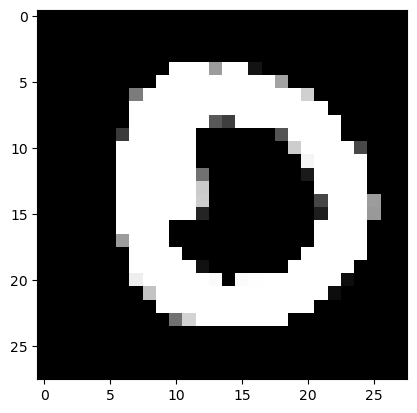

In [20]:
plt.imshow(adv_untargeted[0][0], cmap="gray")
print(true_label[0])

tensor(0)


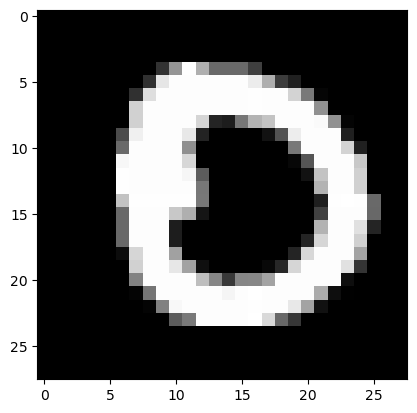

In [21]:
plt.imshow(cln_data[0][0], cmap="gray")
print(true_label[0])

In [ ]:
optimizer = optim.Adam(net.parameters(), lr=0.0003)
for e in range(5):
    loss_avg, acc_avg, num_exp = 0, 0, 0
    net.train()
    for i, data in enumerate(trainloader):
        imgs, labels = data

        n_b = labels.shape[0]

        outputs = net(imgs)
        loss = nn.CrossEntropyLoss(outputs, labels)

        acc = np.sum(np.equal(np.argmax(outputs.data.numpy(), axis=-1), labels.data.numpy()))

        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_avg /= num_exp
    acc_avg /= num_exp
    print(f"[{e +1}, {i+1:5d}] loss: {loss_avg:.3f}, accuracy: {acc_avg:.3f}")